In [1]:
#Import libraries

import pandas as pd
from datetime import datetime
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, roc_curve, auc
import shap
from math import sqrt


In [2]:
#Import Data after preprocessed in SQL

df=pd.read_csv('C:/Trupanion/MonthsPetData.txt',sep='\t',parse_dates=['MinDate'])


In [3]:
#Fill dependent variable with 0 where it is null

df['ClaimAmount']=df['ClaimAmount'].fillna(0)


In [4]:
#Split Data into X and Y
#Get Valid Columns

filter_col = [col for col in df if col.startswith('Claim') or col.startswith('Past')]
filter_col.remove('ClaimAmount')
X1=df[['MonthNumber','MonthYear','MinDate','TotalDays','DaysInPolicy','Species','Breed','AgeAtEnroll','MinAgeInDays','MaxAgeInDays','TotalDaysInPolicy','TotalMonthsInPolicy']]
X2=df[filter_col]
XCombined = X1.join(X2)


In [5]:
#One Hot Encode categorical variables

X = pd.get_dummies(XCombined, prefix_sep="_", columns=['Breed','Species','AgeAtEnroll'])
y=df[['MinDate','ClaimAmount','PetId']]


In [6]:
#Create Train/Test Splits
#Test on previous year for accuracy

date=pd.Timestamp(2018,7,1)
X_train=X.loc[X['MinDate']<date]
y_train=y.loc[y['MinDate']<date]
X_test=X.loc[X['MinDate']==date]
y_test=y.loc[y['MinDate']==date]
X_train.drop('MinDate',axis='columns',inplace=True)
X_test.drop('MinDate',axis='columns',inplace=True)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
#Use Randomized Search CV to tune parameters

gridParams = {
    'max_depth': [4,8,16],
    'min_child_samples': [20,60,100],
    'learning_rate': [0.005,0.01],
    'n_estimators': [40],
    'num_leaves': [16,32],
    'boosting_type' : ['gbdt'],
    'colsample_bytree' : [0.6, 0.65, 0.7],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4]
    }

regressor = LGBMRegressor()

grid = RandomizedSearchCV(regressor, gridParams,
                    verbose=0,
                    cv=5,
                    n_jobs=8,
                    n_iter=50)

grid.fit(X_train, y_train['ClaimAmount'])
# Print the best parameters found

print(grid.best_params_)
print(grid.best_score_)


{'subsample': 0.75, 'reg_lambda': 1, 'reg_alpha': 1.2, 'num_leaves': 32, 'n_estimators': 40, 'min_child_samples': 100, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'boosting_type': 'gbdt'}
0.02435723386823955


In [8]:
#Run Regression using best params

regressor = LGBMRegressor(**grid.best_params_)
regressor.fit(X=X_train,y=y_train['ClaimAmount']) #training the algorithm
y_pred = regressor.predict(X_test)


In [9]:
#Use Normalized Gini as a parameter (https://www.kaggle.com/oxofff/gini-scorer-cv-gridsearch)

def gini(solution, submission):
    df = zip(solution, submission, range(len(solution)))
    df = sorted(df, key=lambda x: (x[1],-x[2]), reverse=True)
    rand = [float(i+1)/float(len(df)) for i in range(len(df))]
    totalPos = float(sum([x[0] for x in df]))
    cumPosFound = [df[0][0]]
    for i in range(1,len(df)):
        cumPosFound.append(cumPosFound[len(cumPosFound)-1] + df[i][0])
    Lorentz = [float(x)/totalPos for x in cumPosFound]
    Gini = [Lorentz[i]-rand[i] for i in range(len(df))]
    return sum(Gini)

def normalized_gini(solution, submission):
    normalized_gini = gini(solution, submission)/gini(solution, solution)
    return normalized_gini


In [10]:
#Compare normalized gini and Mean Squared Error
#Use mean as a benchmark

y_test['ClaimAmountAvg']=y_test.mean().values[0]
print(normalized_gini(y_test['ClaimAmount'], y_pred))#0.679
print(sqrt(mean_squared_error(y_test['ClaimAmount'], y_pred)))#706
print(normalized_gini(y_test['ClaimAmount'], y_test['ClaimAmountAvg']))#0.075

print(sqrt(mean_squared_error(y_test['ClaimAmount'], y_test['ClaimAmountAvg'])))#711
#Mean Squared Error not much improved, but normalized gini much improved



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
0.679628431895685
706.2686964072117
0.07510351732821566
711.1867456700271


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


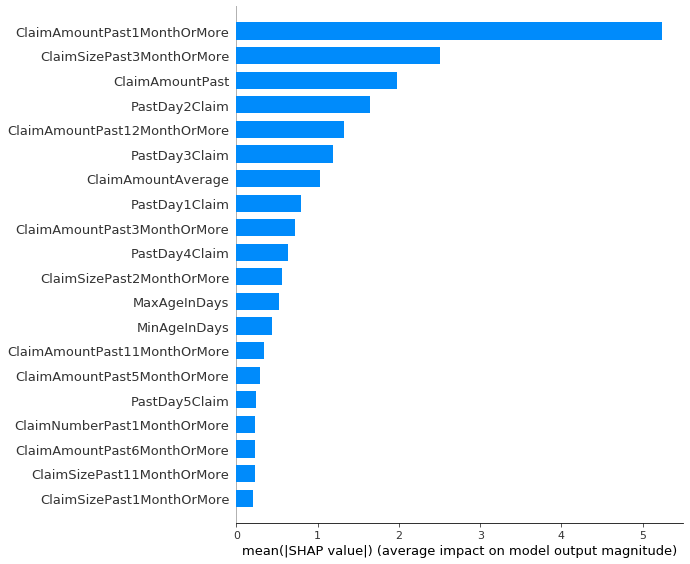

In [11]:
#Use shap to plot LGBM Model

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
#Past values most important for prediction


In [12]:
############
##Real Run
############
#Create Train/Test Splits
#Test on current year

date=pd.Timestamp(2019,7,1)
X_train=X.loc[X['MinDate']<date]
y_train=y.loc[y['MinDate']<date]
X_test=X.loc[X['MinDate']==date]
y_test=y.loc[y['MinDate']==date]
X_train.drop('MinDate',axis='columns',inplace=True)
X_test.drop('MinDate',axis='columns',inplace=True)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
#Use Randomized Search CV to tune parameters

gridParams = {
    'max_depth': [4,8,16],
    'min_child_samples': [20,60,100],
    'learning_rate': [0.005,0.01],
    'n_estimators': [40],
    'num_leaves': [16,32],
    'boosting_type' : ['gbdt'],
    'colsample_bytree' : [0.6, 0.65, 0.7],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4]
    }

regressor = LGBMRegressor()

grid = RandomizedSearchCV(regressor, gridParams,
                    verbose=0,
                    cv=5,
                    n_jobs=8,
                    n_iter=50)

grid.fit(X_train, y_train['ClaimAmount'])


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_...
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.65, 0.7],
                                   

In [14]:
#Run Regression using best params

regressor = LGBMRegressor(**grid.best_params_)
regressor.fit(X=X_train,y=y_train['ClaimAmount']) #training the algorithm
y_pred = regressor.predict(X_test)


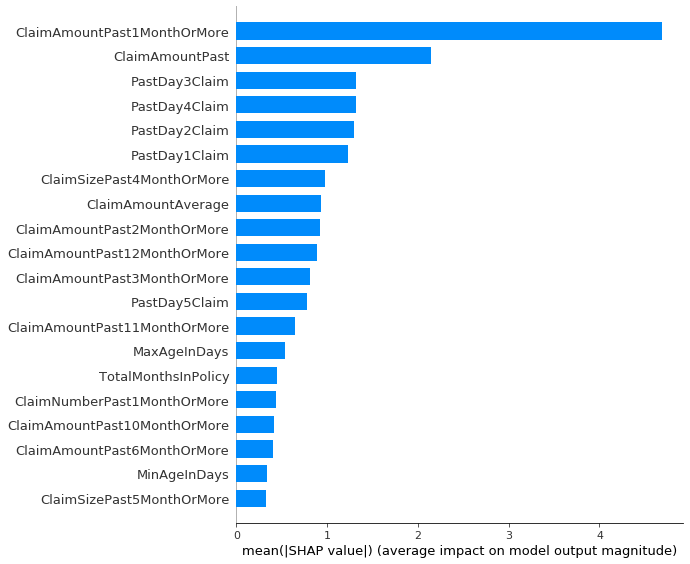

In [15]:
#Use shap to plot LGBM Model

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
#Past values most important for prediction


In [16]:
#Output Final Predictions

y_test['pred'] = y_pred
final=pd.merge(df[['PetId']].drop_duplicates('PetId'),y_test,on='PetId',how='left').fillna(0)
final[['PetId','pred']].to_csv('predictions.csv',header=True,index=False)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
